# Noise Estimation and Adaptive Encoding for Asymmetric Quantum Error Correcting Codes
_Jan Florjanczyk, Supervisor: Todd A. Brun_



In [181]:
% matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import cm
from glob import glob
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_style("whitegrid")
from drift_qec.oneangledephasing import *

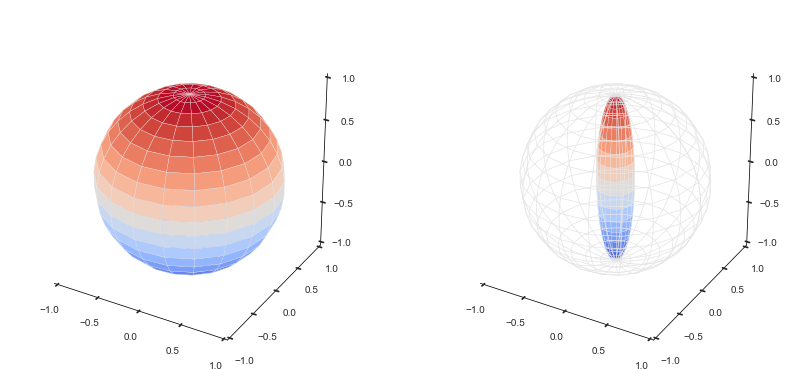

In [194]:
fig = plt.figure(figsize=(14,10))
axs = ["", ""]
axs[0] = fig.add_subplot(121, projection='3d')
axs[1] = fig.add_subplot(122, projection='3d')

axs[0].set_aspect("equal")
axs[0].set_frame_on(False)
axs[0].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].grid(False)

axs[1].set_aspect("equal")
axs[1].set_frame_on(False)
axs[1].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].grid(False)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
axs[0].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)
axs[1].plot_wireframe(x, y, z, color=[0.9, 0.9, 0.9], linewidth=0.75)
x=0.2*np.cos(u)*np.sin(v)
y=0.2*np.sin(u)*np.sin(v)
z=1.0*np.cos(v)
axs[1].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)

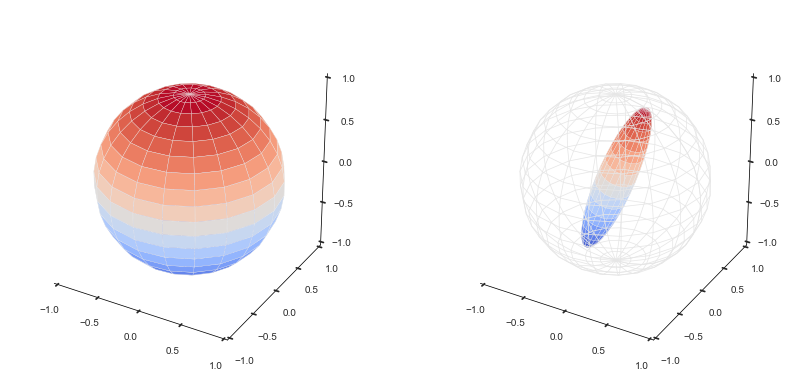

In [195]:
fig = plt.figure(figsize=(14,10))
axs = ["", ""]
axs[0] = fig.add_subplot(121, projection='3d')
axs[1] = fig.add_subplot(122, projection='3d')

axs[0].set_aspect("equal")
axs[0].set_frame_on(False)
axs[0].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].grid(False)

axs[1].set_aspect("equal")
axs[1].set_frame_on(False)
axs[1].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].grid(False)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
axs[0].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)
axs[1].plot_wireframe(x, y, z, color=[0.9, 0.9, 0.9], linewidth=0.75)
x0=0.2*np.cos(u)*np.sin(v)
y0=0.2*np.sin(u)*np.sin(v)
z0=1.0*np.cos(v)
x = x0*np.sin(-1.2) + z0*np.cos(-1.2)
y = y0
z = x0*np.cos(-1.2) - z0*np.sin(-1.2)
axs[1].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)

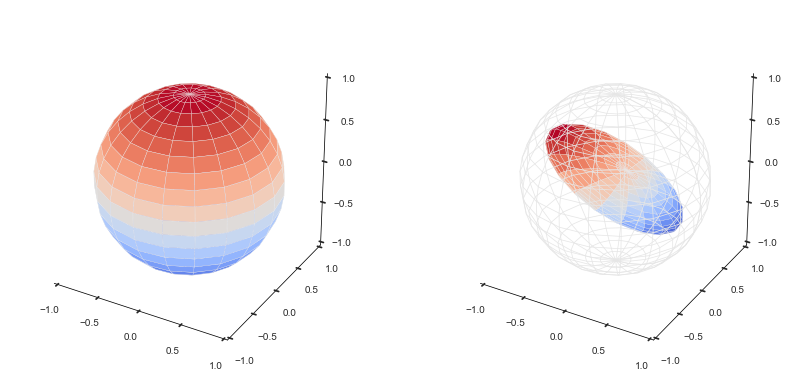

In [196]:
fig = plt.figure(figsize=(14,10))
axs = ["", ""]
axs[0] = fig.add_subplot(121, projection='3d')
axs[1] = fig.add_subplot(122, projection='3d')

axs[0].set_aspect("equal")
axs[0].set_frame_on(False)
axs[0].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].grid(False)

axs[1].set_aspect("equal")
axs[1].set_frame_on(False)
axs[1].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].grid(False)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
axs[0].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)
axs[1].plot_wireframe(x, y, z, color=[0.9, 0.9, 0.9], linewidth=0.75)
x0=0.5*np.cos(u)*np.sin(v)
y0=0.9*np.sin(u)*np.sin(v)
z0=0.2*np.cos(v)
x1 = x0*np.sin(0.5) + y0*np.cos(0.5)
y1 = x0*np.cos(0.5) - y0*np.sin(0.5)
z1 = z0
x = x1*np.sin(-0.8) + z1*np.cos(-0.8)
y = y1
z = x1*np.cos(-0.8) - z1*np.sin(-0.8)
axs[1].plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm)

## Fixed angle dephasing channel

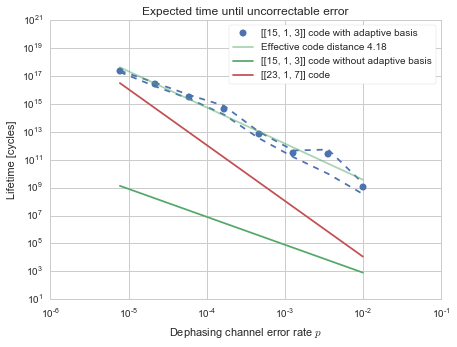

In [166]:
df = pd.read_csv("data/OneAngleDephasingFixed/src.csv", index_col=0)
times = df[["rate", "time"]].groupby(["rate"]).aggregate([np.mean, sp.stats.sem])
times.columns=["mean", "sem"]

x = np.log(times["mean"].index)
y = np.log(times["mean"].values)
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x,y)
f = np.exp(intercept + x * slope)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.loglog(times.index, times["mean"], marker="o", ls="",
          color=sns.color_palette()[0], label="[[15, 1, 3]] code with adaptive basis")
ax.loglog(times.index, times["mean"] - times["sem"], ls="--", color=sns.color_palette()[0])
ax.loglog(times.index, times["mean"] + times["sem"], ls="--", color=sns.color_palette()[0])
ax.loglog(times.index, f, color=sns.color_palette()[1], ls="-",
          label="Effective code distance {:1.2f}".format(-2*slope-1), alpha=0.5)
ax.loglog(times.index, 16.0/(63.0 * 3.141592 * (times.index.values ** 2)),
          color=sns.color_palette()[1], label="[[15, 1, 3]] code without adaptive basis")
ax.loglog(times.index, 1.0/(8855.0 * (times.index.values ** 4)),
          color=sns.color_palette()[2], label="[[23, 1, 7]] code")
ax.axis([1e-6, 1e-1, 1e1, 1e21])
ax.set_title("Expected time until uncorrectable error")
ax.set_xlabel("Dephasing channel error rate $p$")
ax.set_ylabel("Lifetime [cycles]")
ax.legend(frameon=True)
fig.savefig("figures/fixedangledephasinglifetimes.pdf")

## Drifting angle dephasing channel

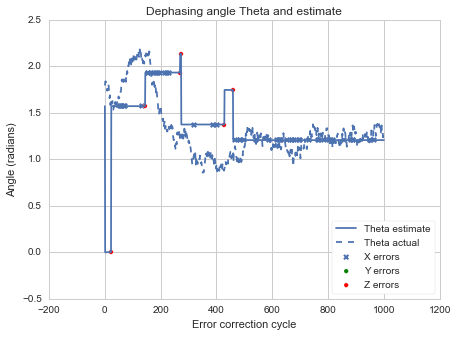

In [42]:
max_time = 1000
params = {"Theta": Theta(max_time, grains=10000, sigma=0.03)}
constants = {"p": Constant(0.003, "p")}

estimator = OneAngleDephasingEstimator(params, constants)
channel = OneAngleDephasingChannel(15, max_time)
report = Report("One Angle Dephasing")

time = 0
while time < max_time:
    s = channel.error(estimator.params, estimator.constants, time)
    estimator.update(s, time)
    report.record(s, time)
    time = time + 1
report.exit(time, "oot", estimator)

fig, ax = plt.subplots(figsize=(7, 5))
report.plot(ax, weightson=True)
ax.legend(frameon=True, loc=4)
ax.set_title("Dephasing angle Theta and estimate")
ax.set_ylabel("Angle (radians)")
ax.set_xlabel("Error correction cycle")
fig.savefig("figures/driftingangledephasingrun.pdf")

In [232]:
df = pd.concat([pd.read_csv(path) for path in glob("data/OneAngleDephasingDriftNew/*.csv")])

In [234]:
s = df.groupby("error_rate").aggregate([np.mean, sp.stats.sem]).reset_index()

In [235]:
s

error_rate  sigma                    exit_time               average_dt  \
               mean           sem           mean           sem       mean   
0      0.001  0.001  1.214073e-20  474941.062500  26657.624918   1.630570   
1      0.010  0.010  9.712587e-20    3176.565625    192.766629   1.832054   

             
        sem  
0  0.066037  
1       NaN

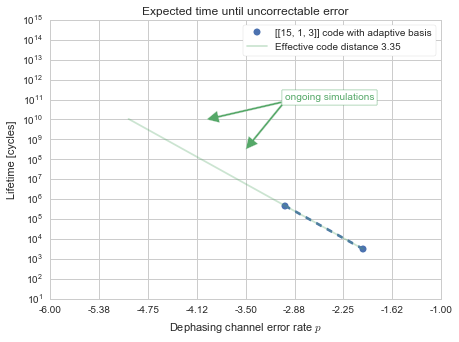

In [237]:
x = np.log(s[("error_rate", )])
y = np.log(s[("exit_time", "mean")])
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x,y)

xmin = -6.0
xmax = -1.0
xn = 9
f = np.exp(intercept) * (np.logspace(-5, -2, xn) ** slope)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.loglog(s[("error_rate", )], s[("exit_time", "mean")], ls="", marker="o",
           color=sns.color_palette()[0], label="[[15, 1, 3]] code with adaptive basis")
plt.loglog(s[("error_rate", )], s[("exit_time", "mean")] - s[("exit_time", "sem")],
           ls="--", color=sns.color_palette()[0])
plt.loglog(s[("error_rate", )], s[("exit_time", "mean")] + s[("exit_time", "sem")],
           ls="--", color=sns.color_palette()[0])
ax.loglog(np.logspace(-5, -2, xn), f, color=sns.color_palette()[1], ls="-",
          label="Effective code distance {:1.2f}".format(-2*slope-1), alpha=0.3)
labels = ["{:1.2f}".format(x) for x in np.linspace(xmin, xmax, xn)]
plt.xticks(np.logspace(xmin, xmax, xn), labels)
plt.axis([(10 ** xmin), (10 ** xmax), 1e1, 1e15])
ax.annotate('ongoing simulations', xy=(1e-4, 1e10), xytext=(1e-3, 1e11), color=sns.color_palette()[1],
            arrowprops=dict(facecolor=sns.color_palette()[1], width=2.0),
            bbox=dict(boxstyle="square", facecolor="white", edgecolor=sns.color_palette()[1])
            )
ax.annotate('ongoing simulations', xy=(10**(-3.5), 10**(8.5)), xytext=(1e-3, 1e11), color=sns.color_palette()[1],
            arrowprops=dict(facecolor=sns.color_palette()[1], width=2.0),
            bbox=dict(boxstyle="square", facecolor="white", edgecolor=sns.color_palette()[1])
            )
plt.legend(frameon=True)
plt.title("Expected time until uncorrectable error")
plt.xlabel("Dephasing channel error rate $p$")
plt.ylabel("Lifetime [cycles]")